In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as sal
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [3]:
data = pd.read_csv('orders.csv')
df = data.copy()
df.head()

,Order Id,Order Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub Category,Product Id,cost price,List Price,Quantity,Discount Percent
0,1,2023-03-01,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,FUR-BO-10001798,240,260,2,2
1,2,2023-08-15,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,FUR-CH-10000454,600,730,3,3
2,3,2023-01-10,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,OFF-LA-10000240,10,10,2,5
3,4,2022-06-18,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,FUR-TA-10000577,780,960,5,2
4,5,2022-07-13,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,OFF-ST-10000760,20,20,2,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Order Id          9994 non-null   int64 
 1   Order Date        9994 non-null   object
 2   Ship Mode         9993 non-null   object
 3   Segment           9994 non-null   object
 4   Country           9994 non-null   object
 5   City              9994 non-null   object
 6   State             9994 non-null   object
 7   Postal Code       9994 non-null   int64 
 8   Region            9994 non-null   object
 9   Category          9994 non-null   object
 10  Sub Category      9994 non-null   object
 11  Product Id        9994 non-null   object
 12  cost price        9994 non-null   int64 
 13  List Price        9994 non-null   int64 
 14  Quantity          9994 non-null   int64 
 15  Discount Percent  9994 non-null   int64 
dtypes: int64(6), object(10)
memory usage: 1.2+ MB


In [5]:
#Clean Data
dataFrame= pd.read_csv('orders.csv', na_values = ['unknown', 'Not Available', 'not available', 'Unknown', ])
dataFrame.columns = dataFrame.columns.str.lower()
dataFrame.columns = dataFrame.columns.str.replace(' ', '_')
dataFrame['order_date'] = pd.to_datetime(dataFrame['order_date'], format = '%Y-%M-%d')


In [6]:
dataFrame.isnull().sum()   # only Six null values in the ship mode column

order_id            0
order_date          0
ship_mode           6
segment             0
country             0
city                0
state               0
postal_code         0
region              0
category            0
sub_category        0
product_id          0
cost_price          0
list_price          0
quantity            0
discount_percent    0
dtype: int64

In [7]:
dataFrame.dropna(axis = 0, how = 'any', inplace = True)
dataFrame.drop_duplicates(inplace = True)

In [8]:
#Adding and necessary columns
dataFrame['discount'] = (dataFrame['list_price'] * dataFrame['discount_percent']) / 100
dataFrame['sale_price'] = dataFrame['list_price'] - dataFrame['discount']
dataFrame['profit'] = dataFrame['sale_price'] - dataFrame['cost_price']
# Cost Price = The Amount for how much seller bought from company
# List price = The Amount for how much customer bought from seller

dataFrame.drop(columns = ['discount_percent', 'country'], inplace = True)
dataFrame.head()


,order_id,order_date,ship_mode,segment,city,state,postal_code,region,category,sub_category,product_id,cost_price,list_price,quantity,discount,sale_price,profit
0,1,2023-01-01 00:03:00,Second Class,Consumer,Henderson,Kentucky,42420,South,Furniture,Bookcases,FUR-BO-10001798,240,260,2,5.2,254.8,14.8
1,2,2023-01-15 00:08:00,Second Class,Consumer,Henderson,Kentucky,42420,South,Furniture,Chairs,FUR-CH-10000454,600,730,3,21.9,708.1,108.1
2,3,2023-01-10 00:01:00,Second Class,Corporate,Los Angeles,California,90036,West,Office Supplies,Labels,OFF-LA-10000240,10,10,2,0.5,9.5,-0.5
3,4,2022-01-18 00:06:00,Standard Class,Consumer,Fort Lauderdale,Florida,33311,South,Furniture,Tables,FUR-TA-10000577,780,960,5,19.2,940.8,160.8
4,5,2022-01-13 00:07:00,Standard Class,Consumer,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,OFF-ST-10000760,20,20,2,1.0,19.0,-1.0


In [9]:
#Loading to Sql Server
def connect_sql(dataFrame): 
    engine = sal.create_engine("mssql+pyodbc://VAISHNAVISPC\\SQLEXPRESS/master?driver=ODBC+Driver+17+for+SQL+Server")
    conn = engine.connect()
    if dataFrame.to_sql(name='OrdersData', con=conn, index=False, if_exists='replace'):
        return True

In [10]:
if connect_sql(dataFrame) == True:
    print('Uploaded Successfully')

Uploaded Successfully


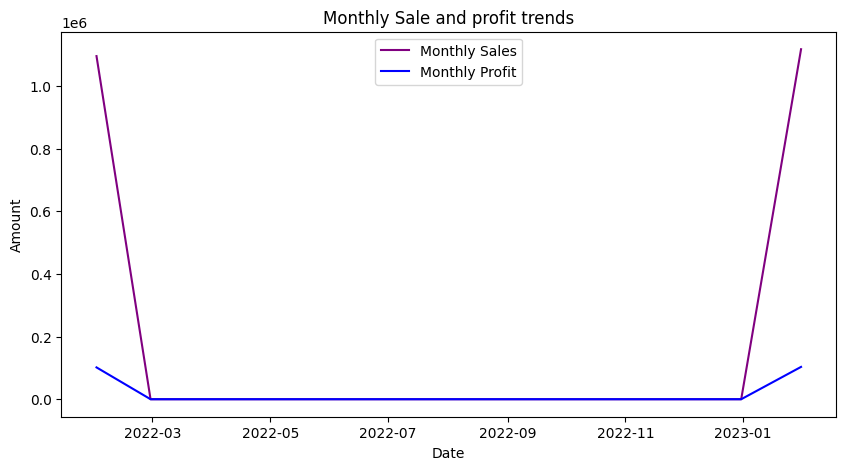

'\n1) The plot suggests that months near to the new years(january to march) yield higher performance to the Seller\n2) Whereas the other months( around mid and towards end of year) yield lower performance to the Seller\n'

In [11]:
#Visualization
monthly_sales = dataFrame.resample('ME', on = 'order_date')['sale_price'].sum()
monthly_profit = dataFrame.resample('ME', on = 'order_date')['profit'].sum()
plt.figure(figsize = (10,5))
plt.plot(monthly_sales.index, monthly_sales, label = 'Monthly Sales', color = 'purple')
plt.plot(monthly_profit.index, monthly_profit, label = 'Monthly Profit', color = 'blue')

plt.xlabel('Date')
plt.ylabel('Amount')
plt.title('Monthly Sale and profit trends')
plt.legend()
plt.show()

"""
1) The plot suggests that months near to the new years(january to march) yield higher performance to the Seller
2) Whereas the other months( around mid and towards end of year) yield lower performance to the Seller
"""


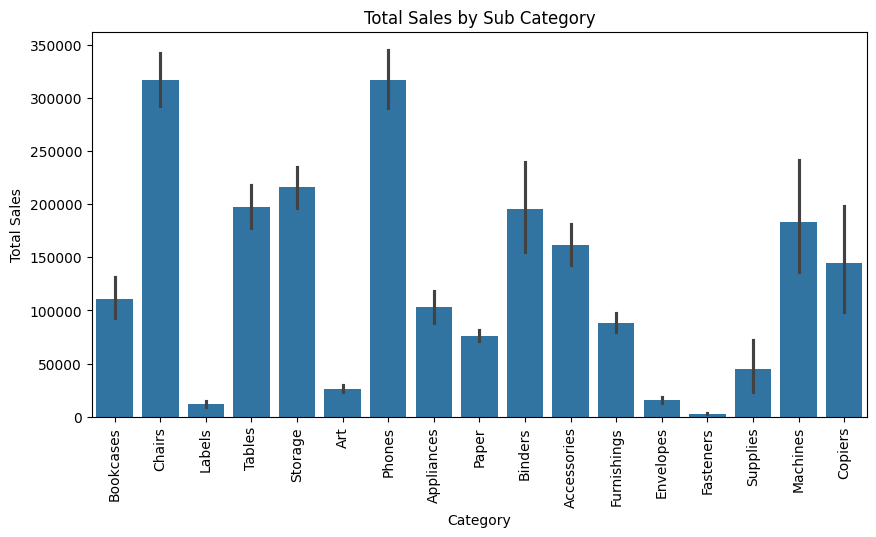

"\n1)From the plot we can clearly see that the sub categories having higher sales are 'Phones', \n        'Chairs', 'Storage', 'Tables' and 'Binders'.\n2) Whereas the Sub categories yielding the least sales to the seller are 'Labels', 'Art' and 'Fasterners'.\n3) The  other Sub Categories have intermediate sales.\n"

In [12]:
# Sales by Sub_category
plt.figure(figsize=(10, 5))
sns.barplot(x='sub_category', y='sale_price', data=dataFrame, estimator=sum)
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.title('Total Sales by Sub Category')
plt.xticks(rotation=90)
plt.show()
"""
1)From the plot we can clearly see that the sub categories having higher sales are 'Phones', 
        'Chairs', 'Storage', 'Tables' and 'Binders'.
2) Whereas the Sub categories yielding the least sales to the seller are 'Labels', 'Art' and 'Fasterners'.
3) The  other Sub Categories have intermediate sales.
"""

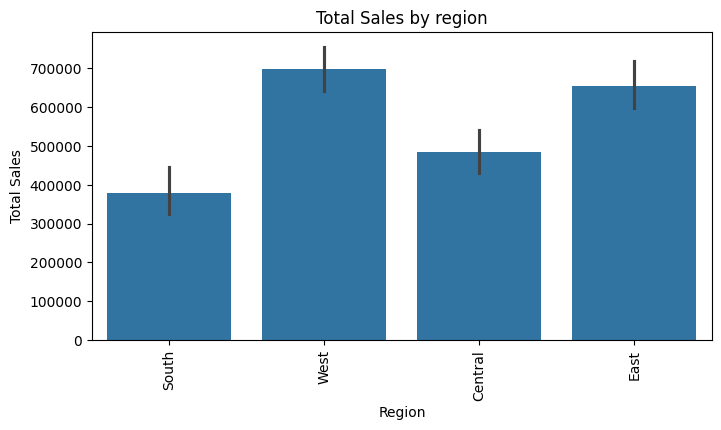

'\n1) The West and East of USA are the regions with highest sales, and the south has the least sale.\n'

In [13]:
# Sales by Region
plt.figure(figsize=(8, 4))
sns.barplot(x='region', y='sale_price', data=dataFrame, estimator=sum)
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.title('Total Sales by region')
plt.xticks(rotation=90)
plt.show()

"""
1) The West and East of USA are the regions with highest sales, and the south has the least sale.
"""

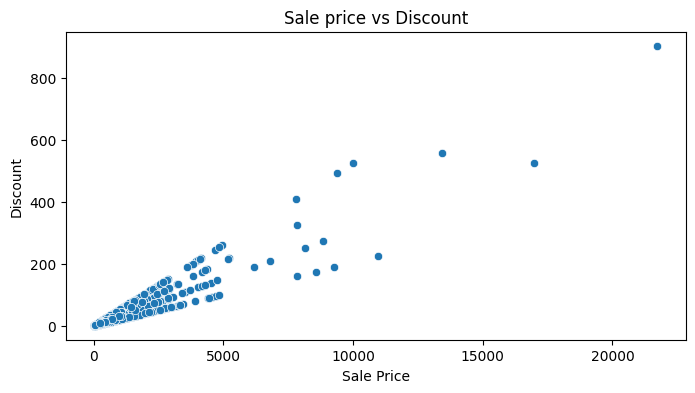

In [21]:
# Scatter plot
plt.figure(figsize = (8, 4))
sns.scatterplot(x = 'sale_price', y = 'discount', data = dataFrame)
plt.xlabel('Sale Price')
plt.ylabel('Discount')
plt.title('Sale price vs Discount')
plt.show()


In [24]:
# Regression Analysis
# y_hat = x0*b0 + x1*b1

x1 = dataFrame['sale_price']
y = dataFrame['discount']

x0 = sm.add_constant(x1)
result = sm.OLS(y, x0).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               discount   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 9.028e+04
Date:                Fri, 06 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:01:12   Log-Likelihood:                -33961.
No. Observations:                9988   AIC:                         6.793e+04
Df Residuals:                    9986   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.077     -0.007      0.995      -0.152       0.151
sale_price     0.0363      0.000    300.468      0.000       0.036       0.036
==============================================================================
Omnibus:                     4362.352   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10122745.534
Skew:                          -0.260   Prob(JB):                         0.00
Kurtosis:                     158.960   Cond. No.                         683.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

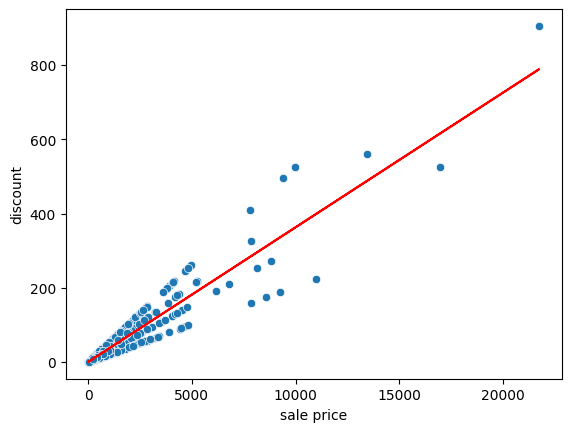

In [27]:
# Plotting the Regression line

sns.scatterplot(x = 'sale_price', y = 'discount', data = dataFrame)
yhat = 0.0363*x1 - 0.0005
fig = plt.plot(x1, yhat, c = 'red', label = 'regression line')
plt.xlabel('sale price')
plt.ylabel('discount')
plt.show()